In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from datacube import helpers

In [3]:
help(helpers.write_geotiff)

Help on function write_geotiff in module datacube.helpers:

write_geotiff(filename, dataset, profile_override=None, time_index=None)
    Write an ODC style xarray.Dataset to a GeoTIFF file.
    
    :param filename: Output filename
    :param dataset: xarray dataset containing one or more bands to write to a file.
    :param profile_override: option dict, overrides rasterio file creation options.
    :param time_index: DEPRECATED



In [4]:
#load modules
import datacube
dc = datacube.Datacube()
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats
import os


In [5]:
#define nessisary gotiff handeling fuctions

import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=True, num_bands=(1), X_band= 1):
    """Blit like
    """
    with rasterio.open(file) as src:

        #|assert src.indexes == num_bands # assume single band
        band = rasterio.band(src, X_band) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

In [6]:
"""#define area
# open  shapfile and data loat from that

shapefile_loc='/g/data/u46/users/ck9738/Datasets/woody_files/test_area_outline.shp'

#import project area shapefiles
project_area = gpd.read_file(shapefile_loc)

#convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long
project_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)

#find the bounding box that contains all the queried projects
#addig 0.025 degrees to the bounding box to be certain the polygons are captured
coords = project_area.total_bounds
xmin, ymax, xmax, ymin =coords"""

"#define area\n# open  shapfile and data loat from that\n\nshapefile_loc='/g/data/u46/users/ck9738/Datasets/woody_files/test_area_outline.shp'\n\n#import project area shapefiles\nproject_area = gpd.read_file(shapefile_loc)\n\n#convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long\nproject_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)\n\n#find the bounding box that contains all the queried projects\n#addig 0.025 degrees to the bounding box to be certain the polygons are captured\ncoords = project_area.total_bounds\nxmin, ymax, xmax, ymin =coords"

In [7]:
""" 
square 60 -149  'lat': (-33.107410, -33.216838),
near parks      'lon': (148.264306, 148.470191),
        'lat': (-33.107410, -33.216838),
        'lon': (148.264306, 148.470191),

big parkes square 60_-149  
        'lat': (-33.0401, -33.2450),
        'lon': (148.2176, 148.5140),


canberra east 62_-159
        'lat': (-35.219946, -35.404461),
        'lon': (149.12468, 149.413767),

canberra west 61_-159
        'lat': (-35.243523, -35.433887),
        'lon': (148.847028, 149.140130),

square 60_-155, Barwang
        'lat': (-34.382385, -34.577689),
        'lon': (148.425899, 148.734517),

"""

" \nsquare 60 -149  'lat': (-33.107410, -33.216838),\nnear parks      'lon': (148.264306, 148.470191),\n        'lat': (-33.107410, -33.216838),\n        'lon': (148.264306, 148.470191),\n\nbig parkes square 60_-149  \n        'lat': (-33.0401, -33.2450),\n        'lon': (148.2176, 148.5140),\n\n\ncanberra east 62_-159\n        'lat': (-35.219946, -35.404461),\n        'lon': (149.12468, 149.413767),\n\ncanberra west 61_-159\n        'lat': (-35.243523, -35.433887),\n        'lon': (148.847028, 149.140130),\n\nsquare 60_-155, Barwang\n        'lat': (-34.382385, -34.577689),\n        'lon': (148.425899, 148.734517),\n\n"

In [8]:
#load satelite data


bands_of_int =['blue', 'green', 'red'
             #'rededge1', 
             #'rededge2', 'rededge3', 'nir1', 'nir2', 'swir1', 'swir2', 'pixel_quality'
              ] #pick the sentinal bands that you want, here i am just using visible light  

query = {
        'lat': (-35.243523, -35.433887),
        'lon': (148.909923, 149.140130),
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'time':('2017-01-01', '2017-03-30')
        }
      
# use s2b_ard_granule 	 for S2B
data_sent = dc.load(product='ls8_nbar_albers', measurements=bands_of_int, group_by='solar_day', **query)
#clear_pixels = np.logical_and(data_sent.pixel_quality != 2, data_sent.pixel_quality != 3)

#data_sent = data_sent.where(clear_pixels)


In [9]:
data_sent

<xarray.Dataset>
Dimensions:  (time: 11, x: 941, y: 951)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-07T23:50:29 2017-01-14T23:56:38 ...
  * y        (y) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
  * x        (x) float64 1.529e+06 1.529e+06 1.529e+06 1.529e+06 1.529e+06 ...
Data variables:
    blue     (time, y, x) int16 672 663 691 702 718 760 761 723 694 680 680 ...
    green    (time, y, x) int16 732 692 753 775 801 858 830 765 741 748 778 ...
    red      (time, y, x) int16 678 650 738 772 784 838 805 742 726 723 764 ...
Attributes:
    crs:      EPSG:3577

In [10]:
"""#generate sentinal geomedian?
#cast the data to float numbers so geomedian calculation will work
data_sent_flt = data_sent.astype(float,casting='safe')

#create geomedian for data
Sentinal_gm=GeoMedian().compute(data_sent_flt)"""


"#generate sentinal geomedian?\n#cast the data to float numbers so geomedian calculation will work\ndata_sent_flt = data_sent.astype(float,casting='safe')\n\n#create geomedian for data\nSentinal_gm=GeoMedian().compute(data_sent_flt)"

In [11]:
Sentinal_time = data_sent.isel(time=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


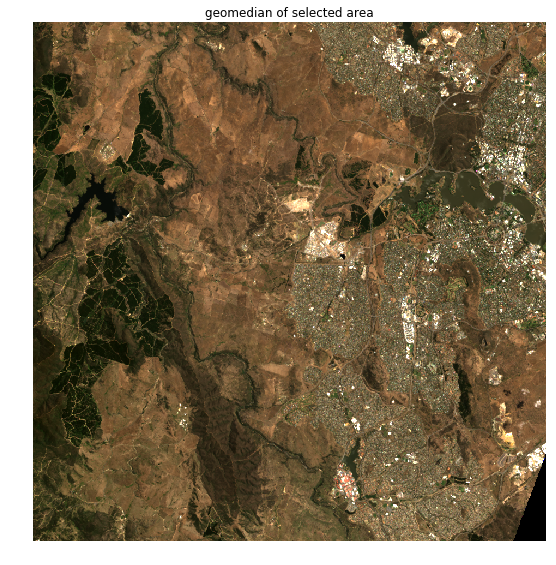

In [12]:
#plot Geomedian
#Prepare geomedian imagery for plotting

rgb = Sentinal_time.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('geomedian of selected area') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [13]:
group_smad_green = {}
band_list = [1,2,3]

In [14]:
#load smad/green product for area
for band in band_list:

    data = rasterfile_to_xarray('/g/data/u46/users/dxr251/woody-v6/woody_61_-159.tif', data_sent.geobox, num_bands=(1,2,3), X_band=band)
    group_smad_green[band] = data

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


In [15]:
group_smad_green

{1: <xarray.DataArray (y: 951, x: 941)>
 array([[0.010921, 0.009851, 0.005748, ..., 1.      , 1.      , 1.      ],
        [0.006256, 0.00519 , 0.004815, ..., 1.      , 1.      , 1.      ],
        [0.006442, 0.002935, 0.003505, ..., 1.      , 1.      , 1.      ],
        ...,
        [0.00315 , 0.013105, 0.006429, ..., 1.      , 1.      , 1.      ],
        [0.002933, 0.01291 , 0.006887, ..., 1.      , 1.      , 1.      ],
        [0.003728, 0.002986, 0.017175, ..., 1.      , 1.      , 1.      ]],
       dtype=float32)
 Coordinates:
   * y        (y) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
   * x        (x) float64 1.529e+06 1.529e+06 1.529e+06 1.529e+06 1.529e+06 ...
 Attributes:
     crs:      EPSG:3577, 2: <xarray.DataArray (y: 951, x: 941)>
 array([[0.878436, 0.914749, 0.79621 , ..., 1.      , 1.      , 1.      ],
        [0.903226, 0.934426, 0.795925, ..., 1.      , 1.      , 1.      ],
        [0.915531, 0.931429, 0.868968, ..., 1.      , 1.      , 1.      ],
   

In [16]:
data_smad_green = xr.concat([group_smad_green[1],group_smad_green[2],group_smad_green[3]], 'band')
ori_n,ori_y,ori_x=data_smad_green.shape
data_smad_green[2]

<xarray.DataArray (y: 951, x: 941)>
array([[0.790723, 0.829609, 0.743426, ..., 1.      , 1.      , 1.      ],
       [0.832974, 0.870393, 0.747559, ..., 1.      , 1.      , 1.      ],
       [0.820683, 0.872904, 0.81841 , ..., 1.      , 1.      , 1.      ],
       ...,
       [0.738364, 0.734915, 0.717715, ..., 1.      , 1.      , 1.      ],
       [0.727721, 0.718509, 0.721613, ..., 1.      , 1.      , 1.      ],
       [0.717685, 0.712585, 0.717334, ..., 1.      , 1.      , 1.      ]],
      dtype=float32)
Coordinates:
  * y        (y) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
  * x        (x) float64 1.529e+06 1.529e+06 1.529e+06 1.529e+06 1.529e+06 ...
Attributes:
    crs:      EPSG:3577

In [17]:
#transform into format to feed to algorithm
flat_smad_green = data_smad_green.stack(z=('y','x')) #we stack Y and X together to make the array 2D, where shape is 
                                                  # N_samples x N_features
    
flat_smad_green = flat_smad_green.transpose()#transpose so sample numbers is first dimention. This is what the machine 
flat_smad_green                             #learning algarithm wants 

<xarray.DataArray (z: 894891, band: 3)>
array([[0.010921, 0.878436, 0.790723],
       [0.009851, 0.914749, 0.829609],
       [0.005748, 0.79621 , 0.743426],
       ...,
       [1.      , 1.      , 1.      ],
       [1.      , 1.      , 1.      ],
       [1.      , 1.      , 1.      ]], dtype=float32)
Coordinates:
  * z        (z) MultiIndex
  - y        (z) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
  - x        (z) float64 1.529e+06 1.529e+06 1.529e+06 1.529e+06 1.529e+06 ...
Dimensions without coordinates: band
Attributes:
    crs:      EPSG:3577

In [18]:
#load traning data
panda_training= pd.read_csv('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/shapefiles_for_train/ausapls_urbare_green_1.csv',
                            usecols=(1,2,3,4,5))

panda_training

,1,2,3,4
0,0.221798,0.824595,0.360918,0.463676
1,0.268886,0.880180,0.368401,0.511779
2,0.247288,0.852440,0.372851,0.479588
3,0.103957,0.680081,0.372909,0.307171
4,0.034268,0.508046,0.362578,0.145468
5,0.022878,0.465351,0.371549,0.093802
6,0.015805,0.419573,0.372815,0.046757
7,0.012307,0.404598,0.362358,0.042240
8,0.012294,0.395893,0.355619,0.040274
9,0.010185,0.378098,0.349083,0.029015


In [21]:
training_features = panda_training.as_matrix(columns=['1','2','3']) #create Array of features for training
training_class = panda_training.as_matrix(columns=['class']) #create Array of classification answer for training
training_class

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0.46367636],
       [0.51177853],
       [0.47958824],
       ...,
       [0.10050726],
       [0.06844986],
       [0.05731416]])

In [22]:
#define machine learning algarithm 
classify = ExtraTreesClassifier(bootstrap=False, max_depth=10, random_state=0)

classify.fit(training_features,training_class)#fit the moddle to the training data
#train

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


ValueError: Unknown label type: 'continuous'

In [ ]:
#classify area
results=classify.predict(flat_smad_green)

In [ ]:
#return results back to original shape
results_back = results.reshape(ori_y,ori_x)
results_xr = xr.DataArray(results_back,dims=('y', 'x'),name='results')
results_xr = results_xr.astype('int16')
results_xr

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(results_xr)
plt.colorbar(cax)
plt.show()

In [ ]:
#add classification results to dataset
##replace with Geomediam 
Sentinal_time["class"] = results_xr
Sentinal_time
#add smad/green to dataset?

In [25]:
#save dataset as GeoTiff to look at in QGIS
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
helpers.write_geotiff('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/classification_outputs/Can_west_3class_one.tif',Sentinal_time)

In [26]:
def array_topanda_s(array):
    a,b = array.shape
    length_be = int(a)+int(b)
    flat = array.stack(z=('y','x'))
    #ones_array = np.ones_like(flat)
    #ones_array = np.where(flat)
    panda_series = pd.Series(flat)
    return(panda_series)

In [27]:
#turn into panda Dataframe for easy plotting
results_panda = pd.DataFrame(results, columns=['class'])

results_panda['1'] = array_topanda_s(data_smad_green[0])
results_panda['2'] = array_topanda_s(data_smad_green[1])
results_panda['3'] = array_topanda_s(data_smad_green[2])
#results_panda= results_panda.dropna(axis=0, how='any')
results_panda

,class,1,2,3
0,2,0.010921,0.878436,0.790723
1,2,0.010921,0.878436,0.790723
2,2,0.009851,0.914749,0.829609
3,2,0.009851,0.914749,0.829609
4,2,0.009851,0.914749,0.829609
5,2,0.005748,0.796210,0.743426
6,2,0.005748,0.796210,0.743426
7,2,0.004205,0.753805,0.721012
8,2,0.004205,0.753805,0.721012
9,2,0.004205,0.753805,0.721012


In [30]:
colours_class = pd.Series(results)
#colours_class = colours_class.replace(to_replace=[2,1,0],value=['blue','green','orange'])
colours_class = colours_class.replace(to_replace=[0,1,2],value=['darkseagreen','khaki',
                                                                    'forestgreen'])#for 5 classes
colours_class = colours_class.as_matrix()
colours_class

array(['forestgreen', 'forestgreen', 'forestgreen', ..., 'darkseagreen',
       'darkseagreen', 'darkseagreen'], dtype=object)

Text(0.5,1,'scatter of classification result, smad vs max green')

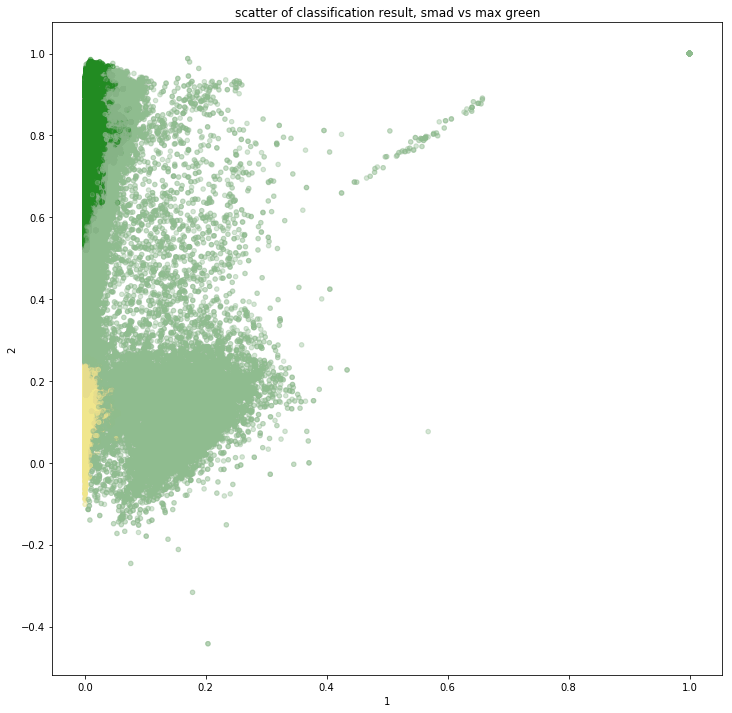

In [33]:
results_panda.plot.scatter('1','2',c=colours_class, figsize=(12,12), alpha=0.1)
plt.title('scatter of classification result, smad vs max green')

Text(0.5,1,'scatter of classification result, smad vs max green')

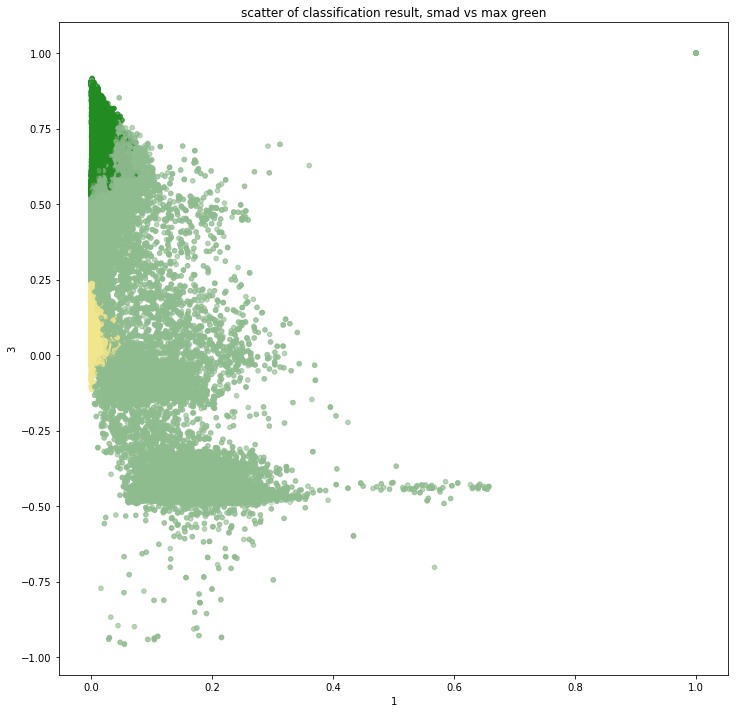

In [32]:
results_panda.plot.scatter('1','3',c=colours_class, figsize=(12,12), alpha=0.2)
plt.title('scatter of classification result, smad vs max green')